In [159]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from experiments.interpretation.experiment_folders import (
    ExperimentFiles,
    ExperimentFolders,
)


notebook_dir = os.path.abspath("")

file_path = os.path.abspath(
    os.path.join(
        notebook_dir,
        "..",
        "results",
        "experiments",
        ExperimentFolders.GPT_41,
        ExperimentFiles.TRIAGE_MCP_SEQ_WEBSEARCH,
    )
)


# Load JSON data (as list of dicts)
with open(file_path) as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Data preparation

In [160]:
# Helper function to count contained and total facts
def count_facts(fact_list):
    if not isinstance(fact_list, list):
        return 0, 0
    total = len(fact_list)
    contained = sum(f.get("is_contained", False) for f in fact_list)
    return contained, total


# Apply to dataframe
df["direct_facts_contained"], df["direct_facts_total"] = zip(
    *df["fact_score.direct_facts"].apply(count_facts)
)
df["supporting_facts_contained"], df["supporting_facts_total"] = zip(
    *df["fact_score.supporting_facts"].apply(count_facts)
)

import numpy as np

# Define conditions based on the 'id' prefix
conditions = [
    df["id"].str.startswith("EA"),
    df["id"].str.startswith("MS"),
    df["id"].str.startswith("PS"),
    df["id"].str.startswith("STC"),
]

# Corresponding labels
labels = [
    "Extensibility Assistance",
    "Malaysia Support",
    "Peppol Support",
    "Settlement Cases",
]

# Create the new column
df["case_type"] = np.select(conditions, labels, default="Unknown")

# Data

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 37 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         91 non-null     object 
 1   question                                   91 non-null     object 
 2   answer                                     91 non-null     object 
 3   product                                    91 non-null     object 
 4   category                                   91 non-null     object 
 5   persona                                    91 non-null     object 
 6   activity                                   91 non-null     object 
 7   country                                    91 non-null     object 
 8   facts                                      91 non-null     object 
 9   bert_score                                 91 non-null     float64
 10  agent_judge_outcome         

In [162]:
df

,id,question,answer,product,category,persona,activity,country,facts,bert_score,...,agent_judge_tokens_consumed.output_tokens,agent_judge_tokens_consumed.total_tokens,tokens_consumed.input_tokens,tokens_consumed.output_tokens,tokens_consumed.total_tokens,direct_facts_contained,direct_facts_total,supporting_facts_contained,supporting_facts_total,case_type
0,EA-1,How can I attach additional files to standard ...,To attach additional files to the standard XML...,ERP (only SAP S/4HANA Cloud Public Edition),How to Develop (Maintenance - Customer case su...,Developer (Customer side),Custom Development,Cross,[{'fact': 'You can attach additional files to ...,0.200006,...,450,15564,17347,2242,19589,2,3,0,5,Extensibility Assistance
1,EA-4,"As a Public Cloud customer in Spain, can I ext...","Yes, as a Public Cloud customer in Spain, you ...",ERP (only SAP S/4HANA Cloud Public Edition),Documentation (Maintenance - Customer case sup...,Developer (Customer side),Custom Development,ES,[{'fact': 'A Public Cloud customer in Spain ca...,0.254973,...,3,6035,5329,593,5922,2,2,1,2,Extensibility Assistance
2,EA-6,"As a Public Cloud customer in Turkey, can I ex...","No. In Public Cloud, eDocument Actions can not...",ERP (only SAP S/4HANA Cloud Public Edition),Documentation (Maintenance - Customer case sup...,Developer (Customer side),Custom Development,TR,"[{'fact': 'In Public Cloud, eDocument Actions ...",0.168062,...,688,10926,8320,2241,10561,0,2,0,0,Extensibility Assistance
3,EA-8,Can I extend an Action in eDocument Cockpit fo...,"Yes, you can extend an action in the eDocument...",ERP (excluding SAP S/4HANA Cloud Public Edition),Documentation (Maintenance - Customer case sup...,Developer (Customer side),Custom Development,Cross,[{'fact': 'You can extend an action in the eDo...,0.101507,...,493,12632,9306,2390,11696,0,2,0,4,Extensibility Assistance
4,EA-2,"For a Greece customer in Public Cloud, what ar...",To enhance the generated XML file for a Greece...,ERP (only SAP S/4HANA Cloud Public Edition),How to Develop (Maintenance - Customer case su...,Developer (Customer side),Custom Development,GR,[{'fact': 'To enhance the generated XML for a ...,0.221292,...,626,26232,14864,2095,16959,4,6,1,3,Extensibility Assistance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,STC-22,For France B2B eInvoice list all the methods w...,From : CL_EDOC_MAP_FR_B2B_SD\n\n- FILL_BILLING...,ERP,Analysis (Development),Architects (Software vendor side),Design,FR,[{'fact': 'The methods that have to be redefin...,-0.018410,...,3,8116,22251,2624,24875,0,9,0,0,Settlement Cases
87,STC-11,"To enable source type ""Settlement Management D...",The method FILL_INVOICE_TYPE_CODE needs to be ...,ERP,Analysis (Development),Developer (Software vendor side),Development,FR,[{'fact': 'The method FILL_INVOICE_TYPE_CODE n...,-0.505764,...,3,11303,17294,1700,18994,0,6,0,1,Settlement Cases
88,STC-12,"To enable source type ""Settlement Management D...",The method FILL_NOTE needs to be redefined fr...,ERP,Analysis (Development),Developer (Software vendor side),Development,FR,[{'fact': 'The method FILL_NOTE needs to be re...,0.311012,...,3,11173,21071,2108,23179,1,1,1,6,Settlement Cases
89,STC-10,"To enable source type ""Settlement Management D...",The method FILL_DELIVERY needs to be redefined...,ERP,Analysis (Development),Developer (Software vendor side),Development,FR,[{'fact': 'The method FILL_DELIVERY needs to b...,-0.340839,...,503,27215,16092,1587,17679,0,3,0,2,Settlement Cases


# Distribution of Direct Fact Scores by Case Type

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_44158/3608582997.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


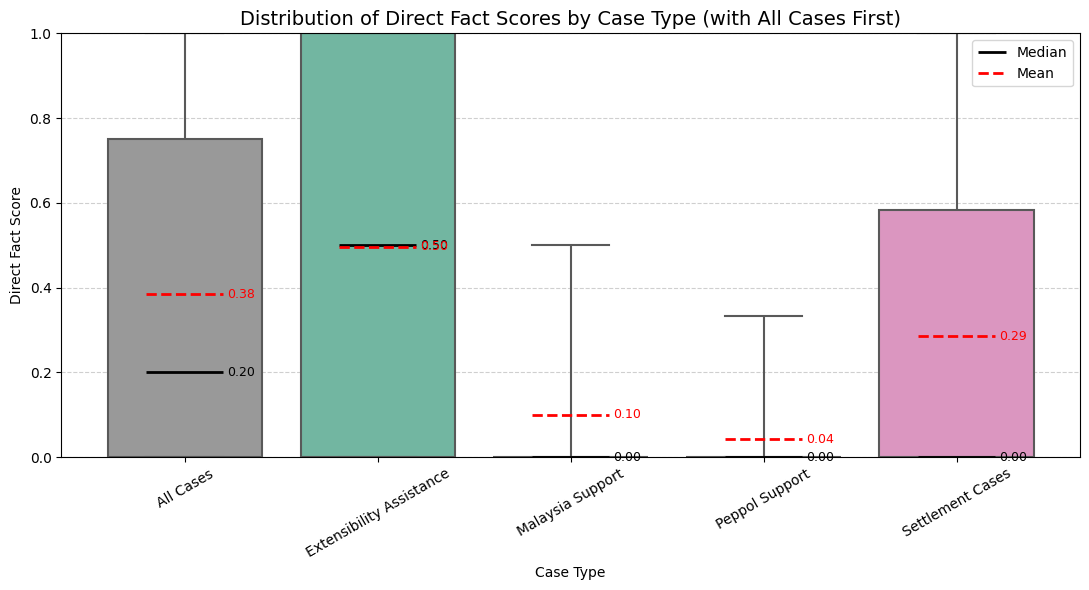

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Add "All Cases" rows
df_all = df.copy()
df_all["case_type"] = "All Cases"
df_combined = pd.concat([df, df_all], ignore_index=True)

# Define custom order (All Cases first)
case_order = [
    "All Cases",
    "Extensibility Assistance",
    "Malaysia Support",
    "Peppol Support",
    "Settlement Cases",
]

# Custom palette including All Cases
custom_palette = {
    "Extensibility Assistance": "#66c2a5",
    "Malaysia Support": "#fc8d62",
    "Peppol Support": "#8da0cb",
    "Settlement Cases": "#e78ac3",
    "All Cases": "#999999",
}

plt.figure(figsize=(11, 6))

# Boxplot with specified order
ax = sns.boxplot(
    data=df_combined,
    x="case_type",
    y="fact_score.direct_fact_score",
    order=case_order,
    palette=custom_palette,
    linewidth=1.5,
    showfliers=False,
    whis=[0, 100],
    medianprops={"visible": False},
)

# Compute mean and median
grouped = df_combined.groupby("case_type")["fact_score.direct_fact_score"]
medians = grouped.median()
means = grouped.mean()

# Add lines and labels
for x, case_type in enumerate(case_order):
    median = medians[case_type]
    mean = means[case_type]

    # Median (black solid)
    ax.hlines(
        median,
        x - 0.2,
        x + 0.2,
        colors="black",
        linestyles="-",
        linewidth=2,
        label="Median" if x == 0 else "",
    )

    # Mean (red dashed)
    ax.hlines(
        mean,
        x - 0.2,
        x + 0.2,
        colors="red",
        linestyles="--",
        linewidth=2,
        label="Mean" if x == 0 else "",
    )

    # Labels
    ax.text(x + 0.22, median, f"{median:.2f}", color="black", va="center", fontsize=9)
    ax.text(x + 0.22, mean, f"{mean:.2f}", color="red", va="center", fontsize=9)

# Plot settings
plt.title(
    "Distribution of Direct Fact Scores by Case Type (with All Cases First)",
    fontsize=14,
)
plt.xlabel("Case Type")
plt.ylabel("Direct Fact Score")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

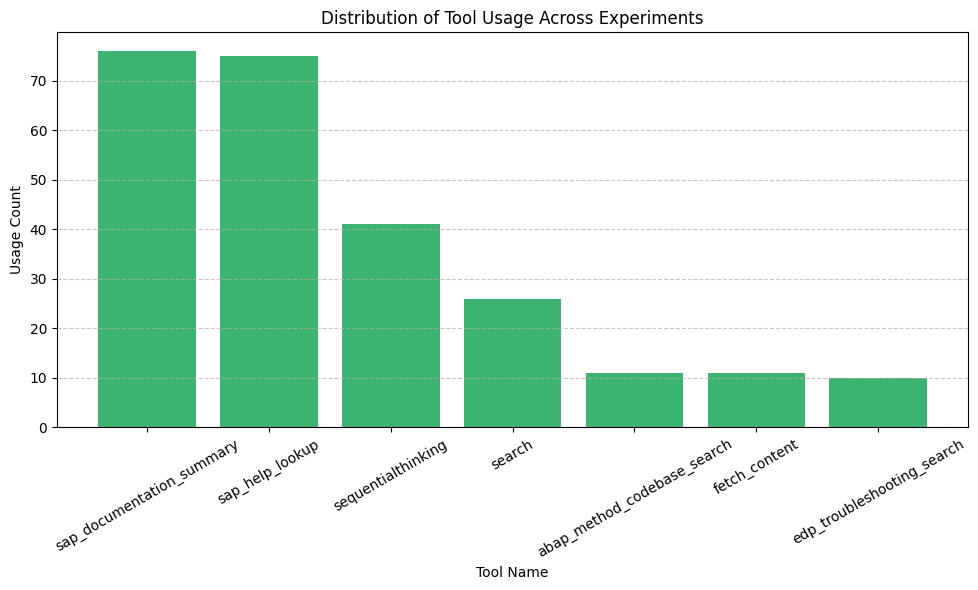

In [164]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# Initialize counter
tool_counts = Counter()

# Loop through each list of tools
for tools_list in df["tools_used"]:
    if isinstance(tools_list, list):
        for tool in tools_list:
            tool_name = tool.get("tool_name")
            if tool_name:
                tool_counts[tool_name] += 1

# Convert to DataFrame
tool_df = pd.DataFrame(tool_counts.items(), columns=["Tool Name", "Usage Count"])
tool_df = tool_df.sort_values(by="Usage Count", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(tool_df["Tool Name"], tool_df["Usage Count"], color="mediumseagreen")
plt.title("Distribution of Tool Usage Across Experiments")
plt.xlabel("Tool Name")
plt.ylabel("Usage Count")
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Correlation Matrix with Direct Fact Score

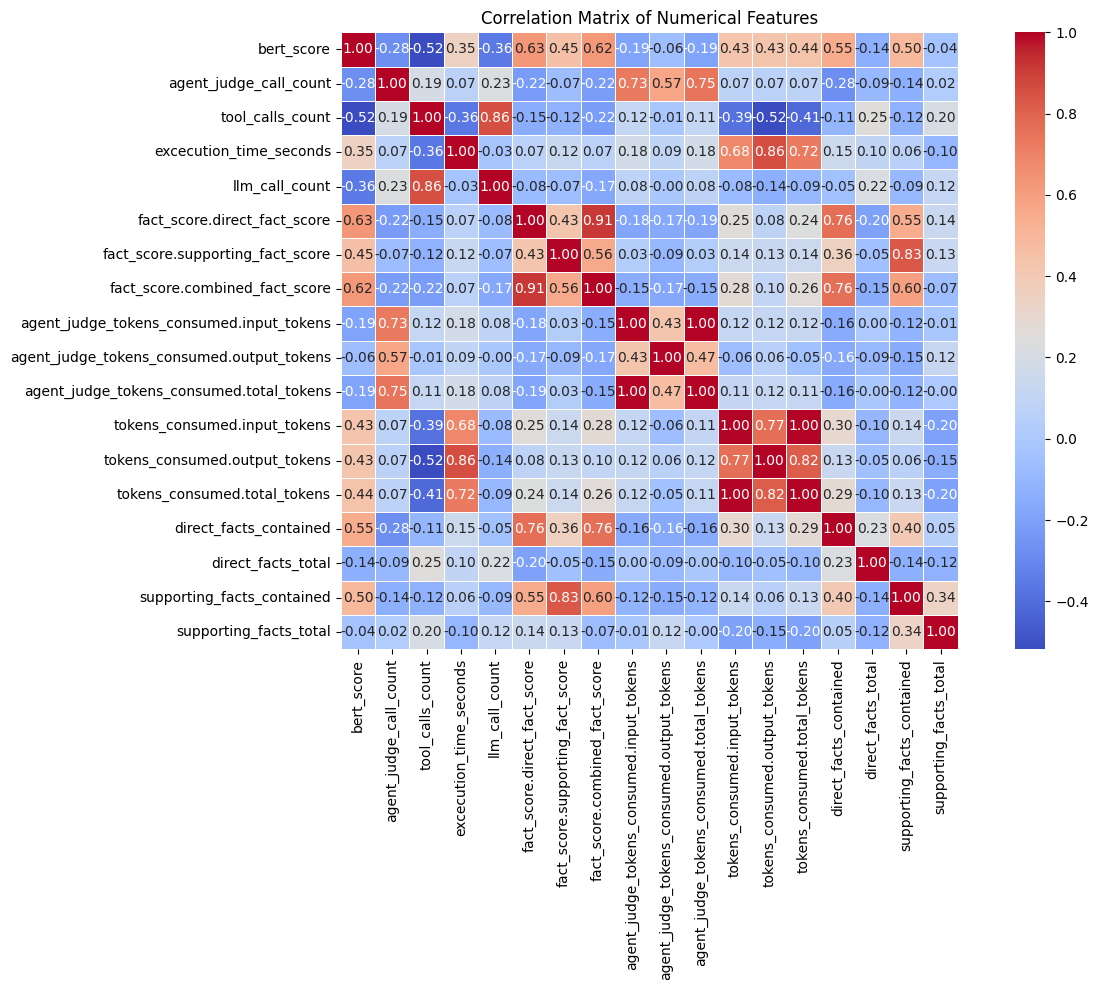

In [165]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns
numeric_df = df.select_dtypes(include=["float64", "int64"])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5
)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()

# Distribution of LLM Judge Outcomes

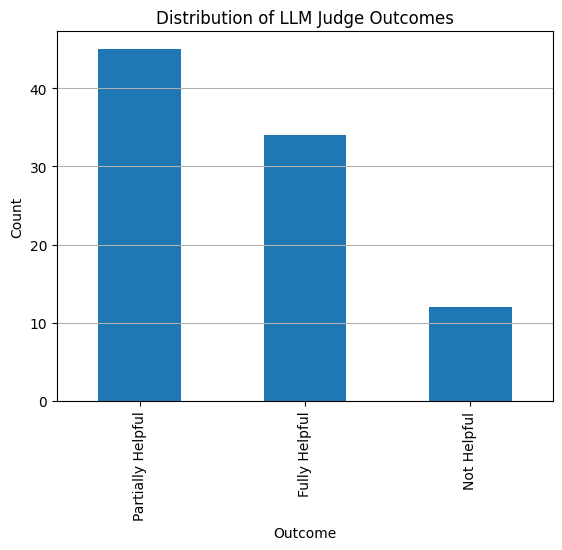

In [166]:
df["agent_judge_outcome"].value_counts().plot(kind="bar")
plt.title("Distribution of LLM Judge Outcomes")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()

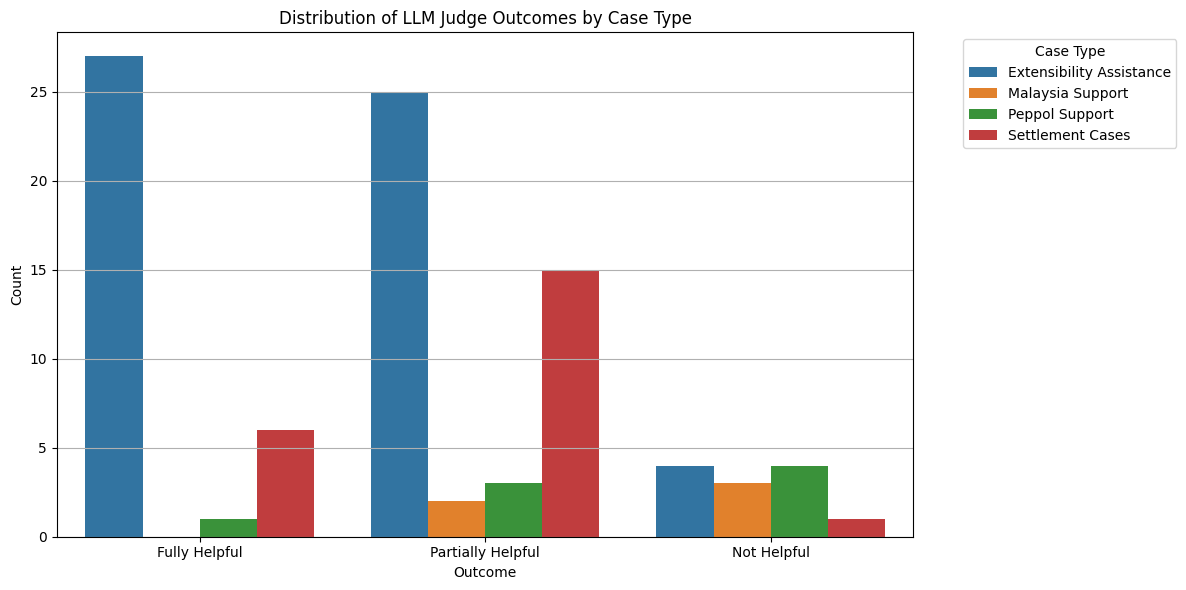

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="agent_judge_outcome", hue="case_type")
plt.title("Distribution of LLM Judge Outcomes by Case Type")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.grid(axis="y")
plt.legend(title="Case Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# BERT Score per Experiment

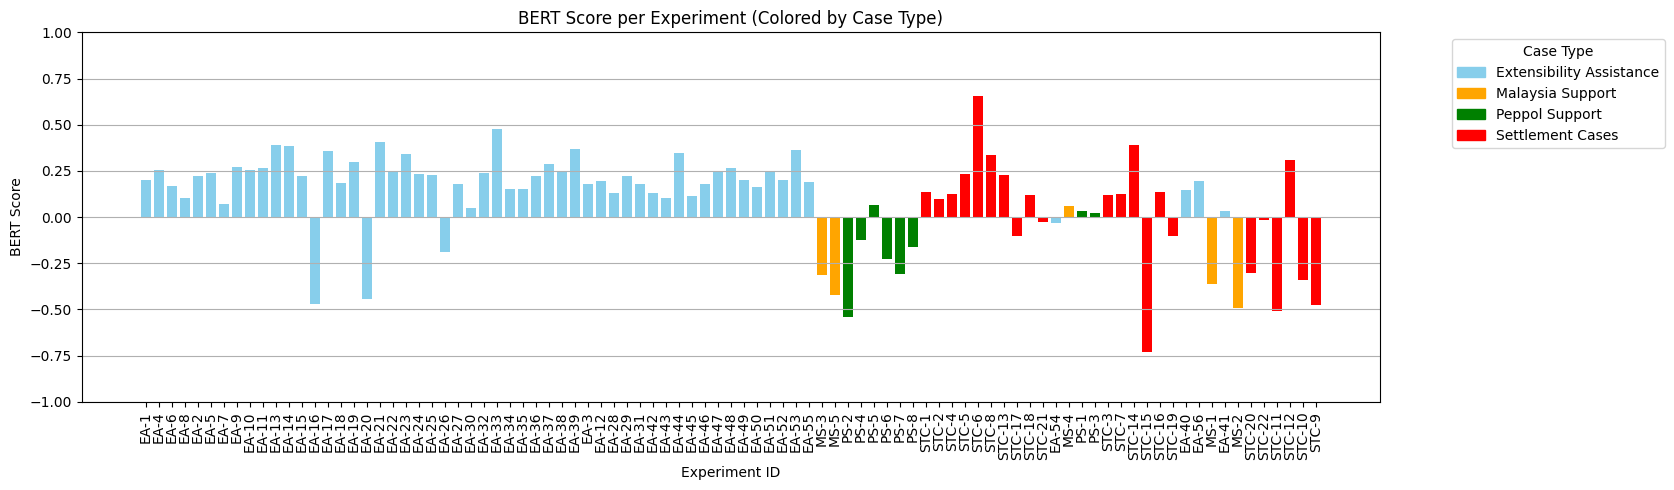

In [168]:
import matplotlib.pyplot as plt

# Define colors for each case_type
case_colors = {
    "Extensibility Assistance": "skyblue",
    "Malaysia Support": "orange",
    "Peppol Support": "green",
    "Settlement Cases": "red",
}

# Map colors to case_type
colors = df["case_type"].map(case_colors)

plt.figure(figsize=(14, 5))
plt.bar(df["id"], df["bert_score"], color=colors)
plt.xlabel("Experiment ID")
plt.ylabel("BERT Score")
plt.title("BERT Score per Experiment (Colored by Case Type)")
plt.ylim(-1, 1)
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.tight_layout()

# Create custom legend
from matplotlib.patches import Patch

legend_handles = [
    Patch(color=color, label=label) for label, color in case_colors.items()
]
plt.legend(
    handles=legend_handles,
    title="Case Type",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

plt.show()

# Average Direct Fact Score by LLM Judge Outcome

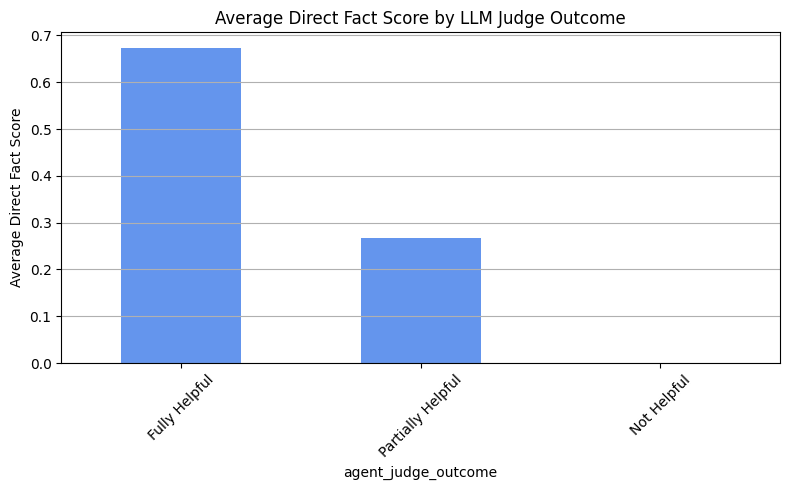

In [169]:
grouped = (
    df.groupby("agent_judge_outcome")["fact_score.direct_fact_score"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 5))
grouped.plot(kind="bar", color="cornflowerblue")
plt.ylabel("Average Direct Fact Score")
plt.title("Average Direct Fact Score by LLM Judge Outcome")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Average Token Consumption by Component

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_44158/675688460.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Agent Judge": [avg_input[0], avg_output[0], avg_total[0]],
/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_44158/675688460.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Agent": [avg_input[1], avg_output[1], avg_total[1]],


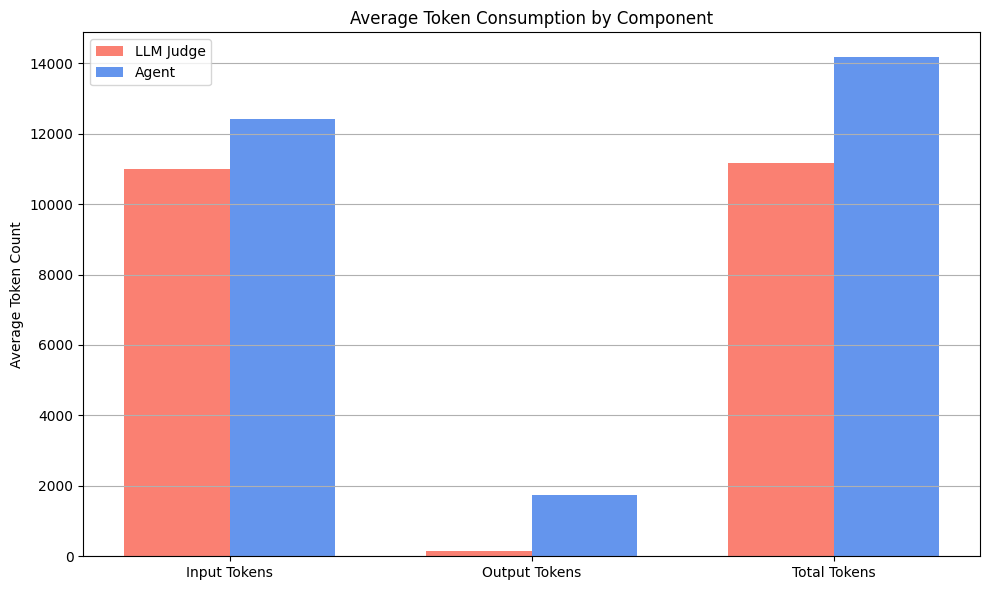

In [170]:
# Calculate average tokens
avg_input = df[
    ["agent_judge_tokens_consumed.input_tokens", "tokens_consumed.input_tokens"]
].mean()
avg_output = df[
    ["agent_judge_tokens_consumed.output_tokens", "tokens_consumed.output_tokens"]
].mean()
avg_total = df[
    ["agent_judge_tokens_consumed.total_tokens", "tokens_consumed.total_tokens"]
].mean()

# Combine into a single DataFrame for plotting
avg_tokens_df = {
    "Agent Judge": [avg_input[0], avg_output[0], avg_total[0]],
    "Agent": [avg_input[1], avg_output[1], avg_total[1]],
}

labels = ["Input Tokens", "Output Tokens", "Total Tokens"]

# Plotting
x = np.arange(len(labels))  # label locations
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(
    x - bar_width / 2,
    avg_tokens_df["Agent Judge"],
    width=bar_width,
    label="LLM Judge",
    color="salmon",
)
plt.bar(
    x + bar_width / 2,
    avg_tokens_df["Agent"],
    width=bar_width,
    label="Agent",
    color="cornflowerblue",
)

plt.xticks(x, labels)
plt.ylabel("Average Token Count")
plt.title("Average Token Consumption by Component")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Fact Contained per Experiment

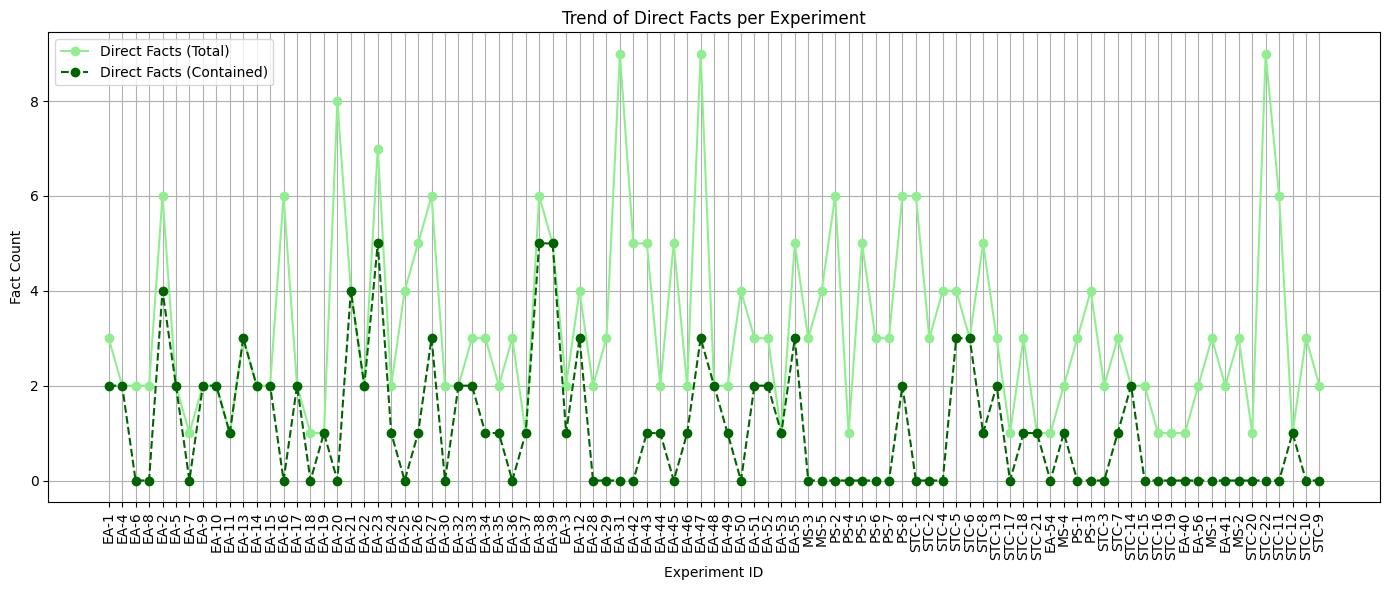

In [171]:
import matplotlib.pyplot as plt
import numpy as np

num_experiments = len(df)
x = np.arange(num_experiments)

plt.figure(figsize=(14, 6))

plt.plot(
    x,
    df["direct_facts_total"],
    marker="o",
    linestyle="-",
    color="lightgreen",
    label="Direct Facts (Total)",
)
plt.plot(
    x,
    df["direct_facts_contained"],
    marker="o",
    linestyle="--",
    color="darkgreen",
    label="Direct Facts (Contained)",
)

plt.xlabel("Experiment ID")
plt.ylabel("Fact Count")
plt.title("Trend of Direct Facts per Experiment")
plt.xticks(x, df["id"], rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()